# Transfer Learning DeepFake
We present a fake detection task on FaceForensic manipulations, performed with the use of a pre-trained **Resnet50 model**. We try to evaluate the performance of the network using transfer learning in two different way:

*   Take the weights of the pretrained model as intial weigths and fine-tuning the pre-trained *ResNet model* on the *FaceForensic dataset*
*   Freezing the weights of all the layer of the pretrained model and going to add, as last layer, one linear layers with a ReLu activation function, which is the only one retrained on the *FaceForensic dataset*.

## IMPORT

In [ ]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import random
import matplotlib.image as mpimg
import pandas as pd
from google.colab import drive
import cv2

cudnn.benchmark = True
plt.ion()   # interactive mode

##Load Data


###Folder

In [ ]:
drive.mount('/content/drive/')
data_dir = '/content/drive/MyDrive/VISIOPE_PROJECT/DataVisionSetMultiClass/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive/


##DataLoader with augmentation and normalization

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
print('Number of file in train set: '+ str(len(image_datasets['train'])))
print('Number of file in val set: '+ str(len(image_datasets['val'])))

Number of file in train set: 3200
Number of file in val set: 400


In [ ]:
print('Number of batches in train dataloader: '+ str(len(dataloaders['train'])))
print('Number of batches in val dataloader: '+ str(len(dataloaders['val'])))

Number of batches in train dataloader: 800
Number of batches in val dataloader: 100


##Visualize a few images

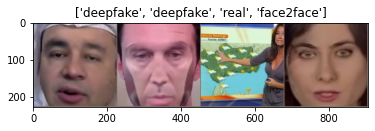

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## Visualizing the model predictions

Generic function to display predictions for a few images



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            print(f'Labels:{labels}')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            print(f'Prediction:{preds}')
            print(f'Input size: {inputs.size()[0]}')
            print(f'Class names: {class_names}')

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## FINETUNING THE RESNET



> REsNet-50 is a deep residual neural network architecture developed by Microsoft. It's a variant of the ResNet architecure, which is designed to improve the trade-off between accuracy and computational cost by addressing the problem of vanishing gradients in deep neural networks.




# RESNET50


> In this situation, we create a pre-trained *ResNet model*, trained on Imagenet, named `model_ft`, and we retrain it on the FaceForensic dataset.

> There, we use an *SGD optimizer*, with a initial learning rate really low ( `lr=0.001`) with a *StepLR scheduler*.






In [ ]:
model_ft = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft

## FINETUNING THE RESNET FREEZING INITIAL LAYERS



> In this situation instead, we create a ResNet pre-trained model, `model_ft_freeze`, we freeze all the weigths of the network and finally we add a `nn.Sequential` composed of one linear layers with a Relu in between.

For this case, we use an *SGD optimezer* with an *StepLR scheduler* which decrease the learning rate every 7 epochs.



In [ ]:
model_ft_freeze = resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model_ft_freeze.parameters():
    param.requiresGrad = False

num_ftrs = model_ft_freeze.fc.in_features

model_ft_freeze.fc = nn.Linear(num_ftrs, 4)

model_ft_freeze = model_ft_freeze.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model_ft_freeze.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft_freeze.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft_freeze

## Define train_model function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss=[]
    val_loss=[]

    train_acc=[]
    val_acc=[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase=='train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return {'model': model, 'train_loss':train_loss, 'val_loss':val_loss, 'train_acc': train_acc, 'val_acc': val_acc}

## Train and evaluate


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0668 Acc: 0.5241
val Loss: 0.7544 Acc: 0.7350

Epoch 1/49
----------
train Loss: 0.6177 Acc: 0.7459
val Loss: 0.4554 Acc: 0.8200

Epoch 2/49
----------
train Loss: 0.4304 Acc: 0.8366
val Loss: 0.4619 Acc: 0.8175

Epoch 3/49
----------
train Loss: 0.3149 Acc: 0.8816
val Loss: 0.3145 Acc: 0.8875

Epoch 4/49
----------
train Loss: 0.2555 Acc: 0.9025
val Loss: 0.3894 Acc: 0.8550

Epoch 5/49
----------
train Loss: 0.1921 Acc: 0.9313
val Loss: 0.2749 Acc: 0.8925

Epoch 6/49
----------
train Loss: 0.1389 Acc: 0.9453
val Loss: 0.2800 Acc: 0.8950

Epoch 7/49
----------
train Loss: 0.0793 Acc: 0.9744
val Loss: 0.2078 Acc: 0.9025

Epoch 8/49
----------
train Loss: 0.0653 Acc: 0.9797
val Loss: 0.1829 Acc: 0.9275

Epoch 9/49
----------
train Loss: 0.0573 Acc: 0.9816
val Loss: 0.2163 Acc: 0.9075

Epoch 10/49
----------
train Loss: 0.0532 Acc: 0.9841
val Loss: 0.1996 Acc: 0.9125

Epoch 11/49
----------
train Loss: 0.0478 Acc: 0.9869
val Loss: 0.1870 Acc: 0.9150

Ep

In [ ]:
model_ft_freeze = train_model(model_ft_freeze, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

# Visualize few image of the model without freezing layers

Labels:tensor([3, 3, 3, 0], device='cuda:0')
Prediction:tensor([3, 3, 3, 0], device='cuda:0')
Input size: 4
Class names: ['deepfake', 'face2face', 'faceswap', 'real']


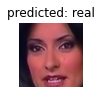

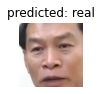

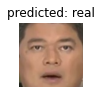

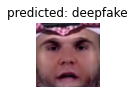

Labels:tensor([3, 2, 3, 2], device='cuda:0')
Prediction:tensor([0, 2, 3, 2], device='cuda:0')
Input size: 4
Class names: ['deepfake', 'face2face', 'faceswap', 'real']


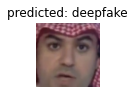

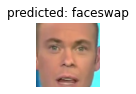

In [ ]:
visualize_model(model_ft['model'])

plt.ioff()
plt.show()

# Visualize few image of the model with freezing layers

Labels:tensor([1, 1, 0, 1], device='cuda:0')
Prediction:tensor([1, 1, 0, 1], device='cuda:0')
Input size: 4
Class names: ['fake', 'real']


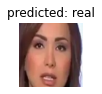

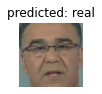

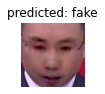

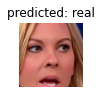

Labels:tensor([1, 0, 0, 1], device='cuda:0')
Prediction:tensor([1, 0, 0, 1], device='cuda:0')
Input size: 4
Class names: ['fake', 'real']


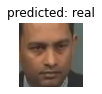

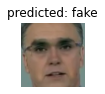

In [ ]:
visualize_model(model_ft_freeze['model'])

plt.ioff()
plt.show()

# Plot Train Loss and Accuracy



> In this section we plot the `training` and `validation loss` and the `accuracy` of our model without freezing layers.


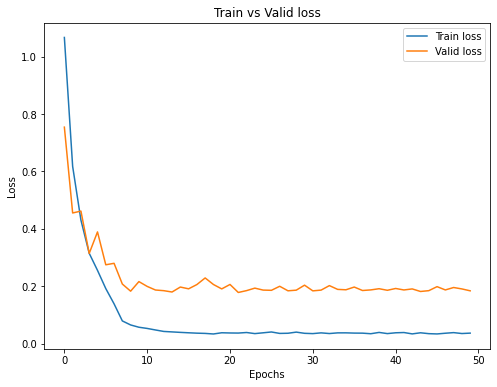

In [ ]:
def plot_logs(train_loss, valid_loss, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_loss))), train_loss, label='Train loss')
    plt.plot(list(range(len(valid_loss))), valid_loss, label='Valid loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(model_ft['train_loss'], model_ft['val_loss'], 'Train vs Valid loss')

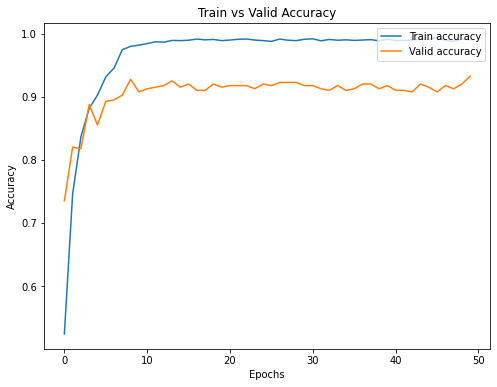

In [ ]:
def plot_acc(train_acc, valid_acc, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_acc))), train_acc, label='Train accuracy')
    plt.plot(list(range(len(valid_acc))), valid_acc, label='Valid accuracy')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper right")

    plt.show()
# oppure model_ft_freeze
plot_acc(model_ft['train_acc'], model_ft['val_acc'], 'Train vs Valid Accuracy')

# Plot Train Loss and Accuracy



> In this section we plot the `training` and `validation loss` and the `accuracy` of our model with freezing layers.


In [ ]:
def plot_logs(train_loss, valid_loss, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_loss))), train_loss, label='Train loss')
    plt.plot(list(range(len(valid_loss))), valid_loss, label='Valid loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(model_ft_freeze['train_loss'], model_ft_freeze['val_loss'], 'Train vs Valid loss')

In [ ]:
def plot_acc(train_acc, valid_acc, title: str):

    plt.figure(figsize=(8,6))

    plt.plot(list(range(len(train_acc))), train_acc, label='Train accuracy')
    plt.plot(list(range(len(valid_acc))), valid_acc, label='Valid accuracy')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper right")

    plt.show()
# oppure model_ft_freeze
plot_acc(model_ft_freeze['train_acc'], model_ft_freeze['val_acc'], 'Train vs Valid Accuracy')

## SAVE THE MODEL

In [ ]:
%cd /content/drive/MyDrive/VISIOPE_PROJECT/models

/content/drive/MyDrive/VISIOPE_PROJECT/models


## WITHOUT FREEZING

In [ ]:
torch.save(model_ft['model'].state_dict(), 'resnet50_deepfake_NORMAL_MULTICLASS.pt')

## FREEZING

In [ ]:
torch.save(model_ft_freeze['model'].state_dict(), 'resnet50_deepfake_MULTICLASS_FREEZE.pt')